## Human Pose Estimation using CNN

The aim of this notebook is to map images of a human to his skeleton (described by the position of 17 main joints of his body).  

We will solve this problem by training a CNN on paired data (human, skeleton), using a dataset containing images of the same person taking different poses (hm36 dataset) associated to their skeleton.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import sys
if "/cvlabdata1/home/gchraibi/pose_estimation/data" not in sys.path:
    sys.path.insert(1, "/cvlabdata1/home/gchraibi/pose_estimation/data")
    
from data.HumanPoseDataset import HumanPoseDataset
from data.helpers import visualize

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "1"         # To change according to GPU filling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Settings parameters
TRAIN = {'train_network': True,
         'save_network_and_losses': False,
         'load_network_and_losses': False, 
         'file_index': None }
TRAIN_AND_SAVE = {'train_network': True,
                  'save_network_and_losses': True,
                  'load_network_and_losses': False, 
                  'file_index': '1' }
LOAD = {'train_network': False,
        'save_network_and_losses': False,
        'load_network_and_losses': True, 
        'file_index': '2' }

CURRENT_SETTINGS = LOAD

### Dataloader

In [4]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

# Instantiation of the train and test dataset/dataloader

ds_train = HumanPoseDataset(is_test = False, root_path = './data/human_cycle/')
dl_train = data.DataLoader(ds_train, **params)

ds_test = HumanPoseDataset(is_test = True, root_path = './data/human_cycle/')
dl_test = data.DataLoader(ds_test, **params)

Loaded 11924 training samples from ./data/human_cycle/
Loaded 2636 testing samples from ./data/human_cycle/


### Networks

In [5]:
# Definition of a CNN with fully connected layer
class CNN_fcl(nn.Module):
    
    def __init__(self):
        super(CNN_fcl, self).__init__()
        # We take a kernel of size 3, because we are dealing with small images (wrist might be often of 1px)
        self._conv2d1 = nn.Conv2d(3,32,3,stride=1,padding=0)
        self._conv2d2 = nn.Conv2d(32,32,3,stride=1,padding=0)
        self._maxpool2d1 = nn.MaxPool2d(kernel_size=2)
        self._conv2d3 = nn.Conv2d(32,64,3,stride=1,padding=0)
        self._conv2d4 = nn.Conv2d(64,64,3,stride=1,padding=0)
        self._conv2d5 = nn.Conv2d(64,128,3,stride=1,padding=0)
        self._conv2d6 = nn.Conv2d(128,128,3,stride=1,padding=0)
        self._maxpool2d2 = nn.MaxPool2d(kernel_size=2)
        self._conv2d7 = nn.Conv2d(128,256,3,stride=1,padding=0)
        self._conv2d8 = nn.Conv2d(256,256,3,stride=1,padding=0)
        self._conv2d9 = nn.Conv2d(256,512,3,stride=1,padding=1)
        self._conv2d10 = nn.Conv2d(512,512,3,stride=1,padding=1)
        self._maxpool2d3 = nn.MaxPool2d(kernel_size=2)
        self._conv2d11 = nn.Conv2d(512,1024,3,stride=1,padding=0)
        self._conv2d12 = nn.Conv2d(1024,1024,3,stride=1,padding=0)
        self._conv2d13 = nn.Conv2d(1024,2048,3,stride=1,padding=1)
        
        # We convert from 2048x4x4 to 2048x1x1, to have each of the 2048 "features" summarised in one element
        self._avg_pool = torch.nn.AvgPool2d(4)
        self._fc1 = nn.Linear(2048, 1024)
        self._fc2 = nn.Linear(1024, 512)
        self._fc3 = nn.Linear(512, 128)
        self._fc4 = nn.Linear(128, 34)

        
    def forward(self, x):
        # No max_pool applied on the first layer to preserve the features
        x = F.relu(self._conv2d1(x))
        x = F.relu(self._conv2d2(x))
        x = self._maxpool2d1(x)
        x = F.relu(self._conv2d3(x))
        x = F.relu(self._conv2d4(x))
        x = F.relu(self._conv2d5(x))
        x = F.relu(self._conv2d6(x))
        x = self._maxpool2d2(x)        
        x = F.relu(self._conv2d7(x))
        x = F.relu(self._conv2d8(x))
        x = F.relu(self._conv2d9(x))
        x = F.relu(self._conv2d10(x))
        x = self._maxpool2d3(x)
        x = F.relu(self._conv2d11(x))
        x = F.relu(self._conv2d12(x))
        x = F.relu(self._conv2d13(x))

        x = self._avg_pool(x)
        x = x.reshape((x.shape[0], -1)) # -1 is a convention to let numpy deduce the other shape
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        x = F.relu(self._fc3(x))
        x = self._fc4(x)

        return x.reshape((x.shape[0], 17, 2))

In [6]:
if not CURRENT_SETTINGS['load_network_and_losses']:
    # Instantiation of the network
    cnn_fcl = CNN_fcl().to(device)
    # Define the loss function
    criterion = nn.L1Loss()
    # Define the optimizer
    learning_rate = 1e-4
    opt = torch.optim.Adam(cnn_fcl.parameters(), lr=learning_rate)

    print(cnn_fcl)

In [7]:
# Train our model
def train_model(model, crit, opt, dl_tr, dl_te, epochs):
    """
    Parameters :
        model  -- Containing parameters
        crit   -- Loss function
        opt    -- Optimisation function
        ds_tr  -- Training dataset
        ds_te  -- Testing dataset
        epochs -- Number of epochs
        
    Return arrays containing the train and test loss at each epoch
    """
    # Array to keep track of the train and test loss at each epoch
    loss_tr_values = []
    loss_te_values = []
    
    for ep in range(epochs):
        # Training mode
        model.train()
        
        # Decay learning rate
        """if (ep == 50 or ep == 100):
            for param_group in opt.param_groups:
                param_group['lr'] = learning_rate/3.0"""
        
        # Variable to accumulate the train loss at one epoch
        loss_tr_run = 0
        
        # Loop for each batches
        for it, batch in enumerate(dl_tr):
            
            # Convert images from bytes to floats and put them in the device (GPU)
            x, target = [d.float().to(device) for d in batch]
            
            # Permute the images from NxHxWxC to NxCxHxW to make it work with pytorch 
            x = x.permute(0,3,1,2)

            # Zero-out the accumulated gradients
            model.zero_grad()
            
            # Run forward pass
            output = model(x)
            
            # Compute the loss
            loss = crit(output, target)
            
            # Run backward pass
            loss.backward()
            
            # Update the weights using optimizer
            opt.step()
            
            loss_tr_run += loss.cpu() 
                        
            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, dl_tr.__len__(), loss_tr_run/(it+1)), end='')
            """
            if (ep%10 == 0 and it == 0):
                with torch.no_grad():
                    img_sample_tr = x.permute(0,2,3,1)[0].cpu().numpy().astype(int)
                    target_sample_tr = target[0].cpu().numpy()
                    output_sample_tr = output[0].cpu().numpy()
            """        
        loss_tr = loss_tr_run / dl_tr.__len__()
        loss_tr_values.append(loss_tr.item())
        
        # Testing mode
        model.eval()
        with torch.no_grad():
            
            # Variable to accumulate the test loss at one epoch
            loss_te_run = 0
            
            for it, batch in enumerate(dl_te):
                # Convert images from bytes to floats and put them in the device (GPU)
                x, target = [d.float().to(device) for d in batch]
                
                # Permute the images from NxHxWxC to NxCxHxW to make it work with pytorch 
                x = x.permute(0,3,1,2)
                
                # Get the output from the test samples through the trained network
                output_te = model(x)
                
                # Compute the loss
                loss = crit(output_te, target)
                
                # Add the loss of the current batch
                loss_te_run += loss.cpu()
                """
                if (ep%10 == 0 and it == 0):
                    img_sample_te = x.permute(0,2,3,1)[0].cpu().numpy().astype(int)
                    target_sample_te = target[0].cpu().numpy()
                    output_sample_te = output_te[0].cpu().numpy()
                """          
            loss_te = loss_te_run / dl_te.__len__()
            loss_te_values.append(loss_te.item())
            print(', loss test: {:.2f}'.format(loss_te))
        
        """
        if (ep%10 == 0):
            visualize(img_sample_tr, target_sample_tr)
            visualize(img_sample_tr, output_sample_tr)
            visualize(img_sample_te, target_sample_te)
            visualize(img_sample_te, output_sample_te)    
        """
    return loss_tr_values, loss_te_values

#### Train network

In [8]:
epochs = 200
if CURRENT_SETTINGS['train_network']:
    loss_tr_values, loss_te_values = train_model(cnn_fcl, criterion, opt, dl_train, dl_test, epochs)

#### Save network and losses

In [9]:
if CURRENT_SETTINGS['save_network_and_losses']:
    # Save network
    network_to_save = {'model': CNN_fcl(),
                       'state_dict': cnn_fcl.state_dict() }
    torch.save(network_to_save, "../../../../home/gchraibi/models/pe_cnn_" 
               + CURRENT_SETTINGS['file_index'] + ".pth")
    # Save losses 
    losses = [loss_tr_values, loss_te_values]
    np.save("../../../../home/gchraibi/losses/pe_cnn_losses_" + CURRENT_SETTINGS['file_index'] + ".npy" , losses)

#### Load network

In [10]:
if CURRENT_SETTINGS['load_network_and_losses']:
    # Load network
    loaded_network = torch.load("../../../../home/gchraibi/models/pe_cnn_" 
                                + CURRENT_SETTINGS['file_index'] + ".pth")
    cnn_fcl = loaded_network["model"].to(device)
    cnn_fcl.load_state_dict(loaded_network['state_dict'])
    cnn_fcl.eval()        # To make it ready to use (in case of dropout, batchnorm layer in the network)
    # Load losses
    losses = np.load("../../../../home/gchraibi/losses/pe_cnn_losses_" + CURRENT_SETTINGS['file_index'] + ".npy")
    loss_tr_values, loss_te_values = losses

### Output & Loss visualisation

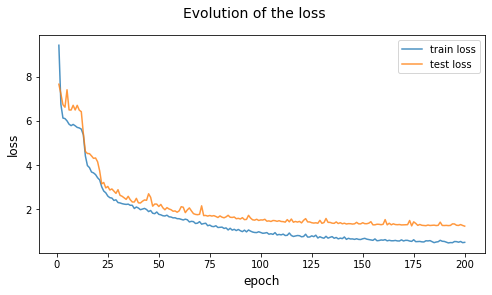

In [11]:
# Visualisation of the evolution of our train loss and test loss

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(np.arange(epochs)+1, loss_tr_values, label='train loss', alpha=0.8)
ax.plot(np.arange(epochs)+1, loss_te_values, label='test loss', alpha=0.8)
ax.set_xlabel('epoch', labelpad=5, fontsize='large')
ax.set_ylabel('loss', labelpad=5, fontsize='large')
ax.legend(loc='best')

fig.suptitle('Evolution of the loss', fontsize=14)
plt.show()

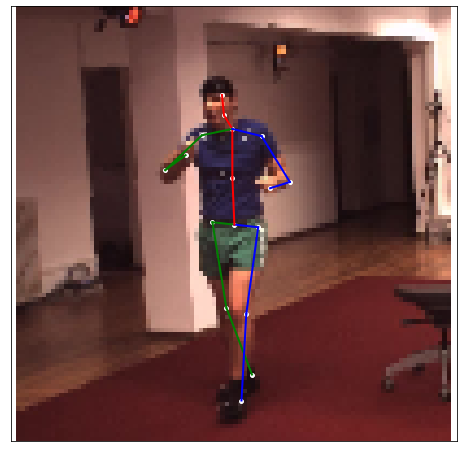

In [12]:
# Get the output from a test sample and visualize it

for it, batch in enumerate(dl_test):
    if (it == 0):
        with torch.no_grad():
            x, target = [d.float().to(device) for d in batch]
            x = x.permute(0,3,1,2) 
            output_test_run = cnn_fcl(x)

            sample_image_test = x.permute(0,2,3,1)[0].cpu().numpy().astype(int)
            sample_output_test = output_test_run[0].cpu().numpy()
            visualize(sample_image_test, sample_output_test)